# Installs & Imports

In [1]:
!pip -q install orbit-ml
!pip -q install arviz
!pip -q install pyjanitor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.9/446.9 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.2/205.2 kB 3.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import orbit
from orbit.models import ETS, DLT, KTR, LGT
from orbit.diagnostics.backtest import BackTester
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.dataset import load_iclaims
from orbit.utils.plot import get_orbit_style
import arviz as az
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import janitor
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Create a custom style
def get_custom_style():
    """Create a custom style."""
    custom_style = {
        'axes.axisbelow': True,
        'axes.edgecolor': 'lightgrey',
        'axes.facecolor': 'None',
        'axes.grid': True,
        'axes.labelcolor': 'dimgrey',
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'figure.facecolor': 'white',
        'font.family': 'sans-serif',
        'font.sans-serif': 'Arial',
        'grid.alpha': 0.5,
        'grid.color': 'lightgrey',
        'grid.linestyle': '--',
        'legend.frameon': False,
        'legend.numpoints': 1,
        'legend.scatterpoints': 1,
        'lines.solid_capstyle': 'round',
        'text.color': 'dimgrey',
        'xtick.color': 'dimgrey',
        'xtick.direction': 'out',
        'ytick.color': 'dimgrey',
        'ytick.direction': 'out',
        'figure.figsize': (8, 4),
        'axes.titlesize': 'large',
        'axes.labelsize': 'medium',
        'xtick.labelsize': 'small',
        'ytick.labelsize': 'small',
        'legend.fontsize': 'small',
    }

    return custom_style

# Apply the custom style
plt.rcParams.update(get_custom_style())

# Data Loading

In [4]:
def load_data():
    """Load and return the iclaims dataset."""
    df = load_iclaims(transform=True)
    return df

In [5]:
# Load data
df = load_data()

# Display the first few rows
display(df.head())
print("\n")

# Check data types
datatypes = df.dtypes
datatypes.rename('Data Type', inplace=True)
display(datatypes)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


,Data Type
week,datetime64[ns]
claims,float64
trend.unemploy,float64
trend.filling,float64
trend.job,float64
sp500,float64
vix,float64


# Data Preprocessing

In [6]:
def preprocess_data(df):
    """Split the data into training and testing sets."""
    # Define the response and date columns
    response_col = 'claims'
    date_col = 'week'

    # Split the data
    test_size = 52  # Use the last year for testing
    train_df = df[:-test_size].reset_index(drop=True)
    test_df = df[-test_size:].reset_index(drop=True)

    return train_df, test_df, date_col, response_col

In [7]:
# Preprocess data
train_df, test_df, date_col, response_col = preprocess_data(df)

# Shapes
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)

Training Data Shape: (391, 7)
Testing Data Shape: (52, 7)


# Data Exploration

In [8]:
def plot_time_series(train_df, test_df, date_col, response_col):
    """Plot the time series data."""
    plt.figure(figsize=(8, 4))
    plt.plot(train_df[date_col], train_df[response_col], label='Training Data')
    plt.plot(test_df[date_col], test_df[response_col], label='Test Data', color='orange')
    plt.title('Time Series of Unemployment Claims')
    plt.xlabel('Date')
    plt.ylabel('Claims')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [9]:
# Install Arial explicitly to avoid warning messages
import matplotlib as mpl
import matplotlib.font_manager as fm
print(mpl.__version__)

!wget -O Arial.ttf https://github.com/justrajdeep/fonts/raw/master/Arial.ttf
font_dirs = ["/content/"]
font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
for font_file in font_files:
    print(font_file) if 'Arial' in font_file else None
    fm.fontManager.addfont(font_file)

3.7.1
--2024-10-31 05:16:56--  https://github.com/justrajdeep/fonts/raw/master/Arial.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Arial.ttf [following]
--2024-10-31 05:16:56--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Arial.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773236 (755K) [application/octet-stream]
Saving to: ‘Arial.ttf’

Arial.ttf           100%[===================>] 755.11K  --.-KB/s    in 0.06s   

2024-10-31 05:16:56 (13.3 MB/s) - ‘Arial.ttf’ saved [773236/773236]

/content/Arial.ttf


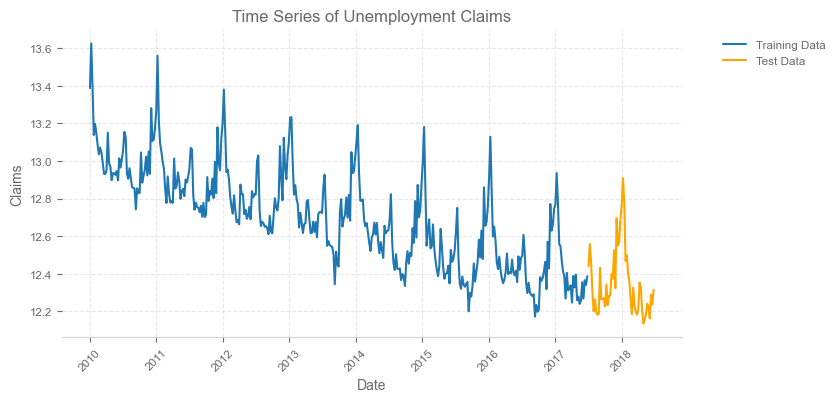

In [10]:
# Plot the time series
plot_time_series(train_df, test_df, date_col, response_col)

In [11]:
def check_stationarity(series):
    """Perform Augmented Dickey-Fuller test to check stationarity."""
    result = adfuller(series)
    print('ADF Statistic: {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))
    for key, value in result[4].items():
        print('Critical Value ({}): {:.4f}'.format(key, value))

    if result[1] <= 0.05:
        print("\nThe series is stationary.")
    else:
        print("\nThe series is not stationary.")

In [12]:
# Check stationarity of the response variable
print("Stationarity Test for 'claims':")
check_stationarity(train_df[response_col])

Stationarity Test for 'claims':
ADF Statistic: -2.0011
p-value: 0.2861
Critical Value (1%): -3.4480
Critical Value (5%): -2.8693
Critical Value (10%): -2.5709

The series is not stationary.


In [13]:
def difference_series(df, col, periods=1):
    """Difference the time series to achieve stationarity."""
    df[f'{col}_diff'] = df[col] - df[col].shift(periods)
    df = df.dropna().reset_index(drop=True)
    return df

In [14]:
# Difference the training data
train_df = difference_series(train_df, response_col)

# Check stationarity again
print("Stationarity Test for Differenced 'claims':")
check_stationarity(train_df[f'{response_col}_diff'])

Stationarity Test for Differenced 'claims':
ADF Statistic: -7.5905
p-value: 0.0000
Critical Value (1%): -3.4481
Critical Value (5%): -2.8693
Critical Value (10%): -2.5709

The series is stationary.


# Feature Engineering

In [15]:
# Define regressors
regressor_col = ['trend.unemploy', 'trend.filling', 'trend.job']

In [16]:
def scale_features(train_df, test_df, features):
    """Scale features using standardization."""
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    train_df[features] = scaler.fit_transform(train_df[features])
    test_df[features] = scaler.transform(test_df[features])
    return train_df, test_df

In [17]:
# Scale the regressors
train_df, test_df = scale_features(train_df, test_df, regressor_col)

# Auxiliary Functions

In [18]:
def wmape(y_true, y_pred):
    """Calculate Weighted Mean Absolute Percentage Error."""
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error."""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
def plot_residuals(test_df, predicted_df, date_col, response_col, model_name):
    """Plot residuals of the model."""
    residuals = test_df[response_col] - predicted_df['prediction']
    plt.figure(figsize=(6, 4))
    plt.plot(test_df[date_col], residuals, marker='o', linestyle='-', label='Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals of {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

In [20]:
def posterior_analysis(model, var_names):
    """Perform posterior analysis using ArviZ."""
    posterior_samples = model.get_posterior_samples()
    az.plot_pair(
        posterior_samples,
        var_names=var_names,
        kind='kde',
        marginals=True,
        figsize=(12, 8),
        textsize=12
    )
    plt.show()

# Modeling with Tuning

## ETS

In [21]:
def tune_ets(train_df, date_col, response_col, seasonality_options):
    """Tune ETS model's seasonality parameter."""
    best_wmape = float('inf')
    best_seasonality = None
    for seasonality in seasonality_options:
        ets = ETS(
            response_col=response_col,
            date_col=date_col,
            seasonality=seasonality,
            estimator='stan-map',
            seed=42,
        )
        ets.fit(train_df)
        predicted_df = ets.predict(df=train_df)
        score = wmape(train_df[response_col], predicted_df['prediction'])
        if score < best_wmape:
            best_wmape = score
            best_seasonality = seasonality
    print(f"Best ETS seasonality: {best_seasonality} with WMAPE: {best_wmape:.4f}")
    return best_seasonality

In [22]:
# Tune ETS seasonality
seasonality_options = [7, 12, 26, 52]
best_seasonality_ets = tune_ets(train_df, date_col, response_col, seasonality_options)

2024-10-31 05:16:58 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:16:58 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:16:58 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:16:59 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.


Best ETS seasonality: 12 with WMAPE: 0.0017


In [23]:
def fit_ets_model(train_df, date_col, response_col, seasonality):
    """Fit an ETS model."""
    ets = ETS(
        response_col=response_col,
        date_col=date_col,
        seasonality=seasonality,
        estimator='stan-mcmc',
        n_bootstrap_draws=1000,
        seed=42,
        prediction_percentiles=[5, 95],
    )
    ets.fit(train_df)
    return ets

In [24]:
# Fit ETS model
ets_model = fit_ets_model(train_df, date_col, response_col, best_seasonality_ets)

2024-10-31 05:16:59 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (CmdStanPy) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [25]:
def make_predictions(model, df, decompose=True):
    """Make predictions using the fitted model."""
    predicted_df = model.predict(df=df, decompose=decompose)
    return predicted_df

In [26]:
# Make predictions
ets_predicted = make_predictions(ets_model, test_df)

In [27]:
def visualize_predictions(train_df, test_df, predicted_df, date_col, response_col, title):
    """Visualize actual vs. predicted values."""
    _ = plot_predicted_data(
        training_actual_df=train_df,
        predicted_df=predicted_df,
        date_col=date_col,
        actual_col=response_col,
        test_actual_df=test_df,
        title=title
    )
    plt.show()

def visualize_components(predicted_df, date_col):
    """Visualize model components."""
    _ = plot_predicted_components(predicted_df=predicted_df, date_col=date_col)
    plt.show()

In [28]:
# Install Arial explicitly to avoid warning messages
import matplotlib as mpl
import matplotlib.font_manager as fm
print(mpl.__version__)

!wget -O Arial.ttf https://github.com/justrajdeep/fonts/raw/master/Arial.ttf
font_dirs = ["/content/"]
font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
for font_file in font_files:
    print(font_file) if 'Arial' in font_file else None
    fm.fontManager.addfont(font_file)

3.7.1
--2024-10-31 05:17:08--  https://github.com/justrajdeep/fonts/raw/master/Arial.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Arial.ttf [following]
--2024-10-31 05:17:08--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Arial.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773236 (755K) [application/octet-stream]
Saving to: ‘Arial.ttf’

Arial.ttf           100%[===================>] 755.11K  --.-KB/s    in 0.05s   

2024-10-31 05:17:08 (14.1 MB/s) - ‘Arial.ttf’ saved [773236/773236]

/content/Arial.ttf


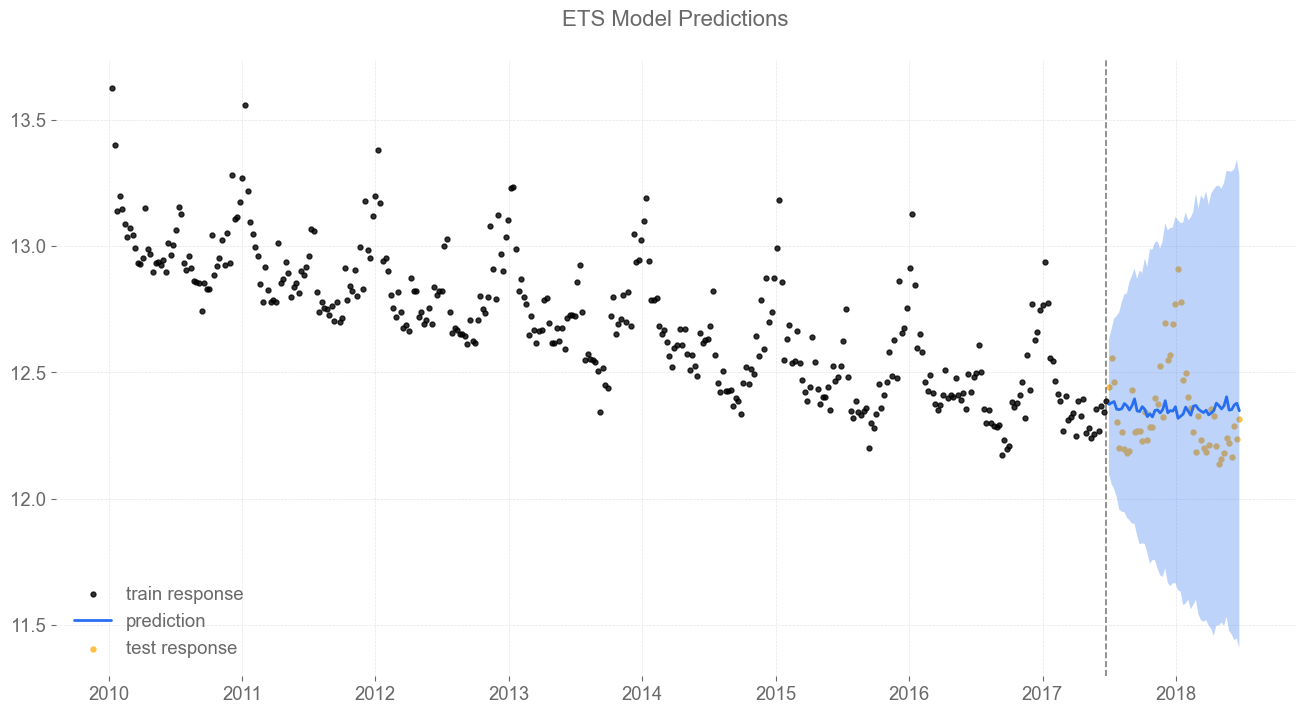

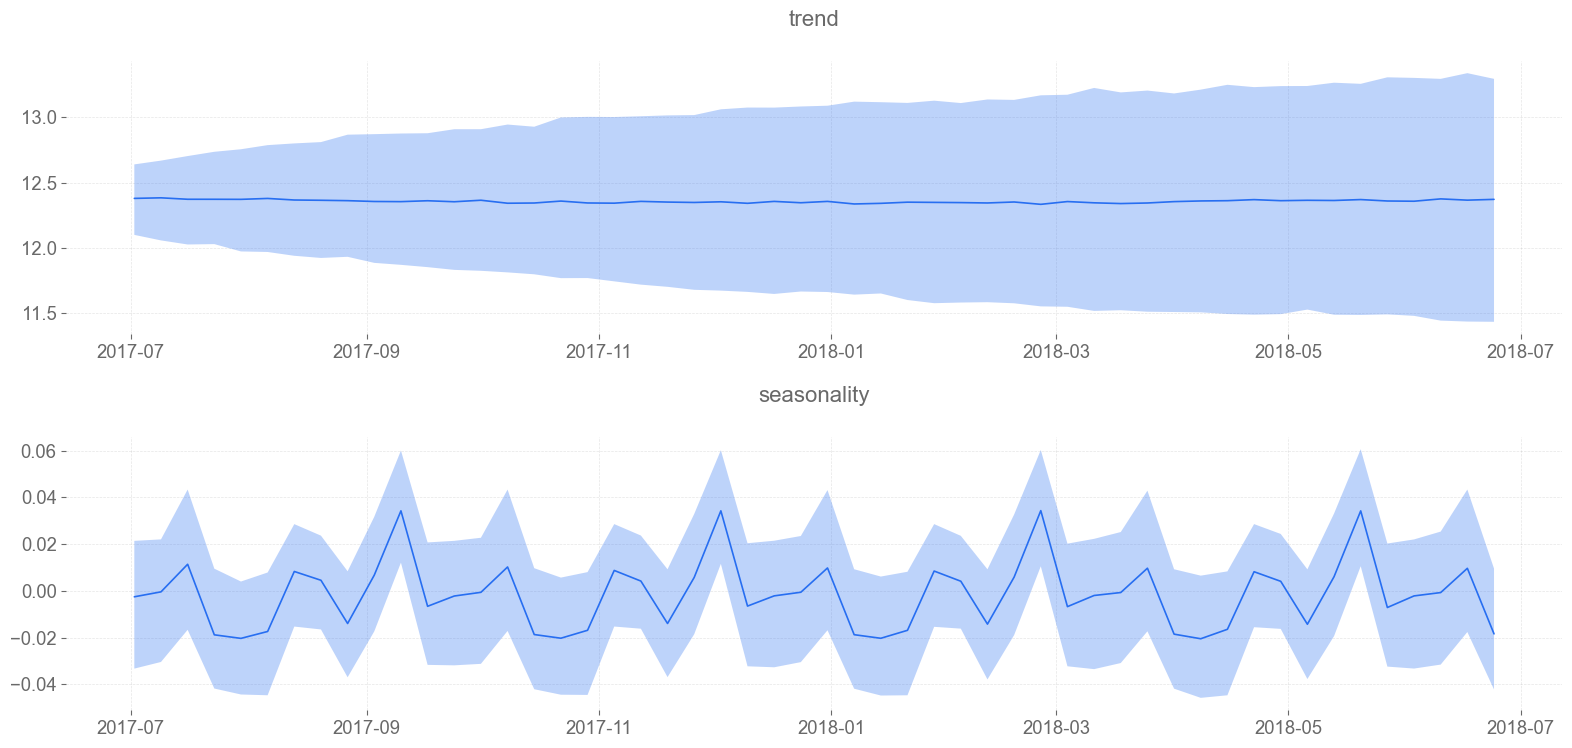

In [29]:
# Visualize predictions
visualize_predictions(train_df, test_df, ets_predicted, date_col, response_col, 'ETS Model Predictions')

# Visualize components
visualize_components(ets_predicted, date_col)

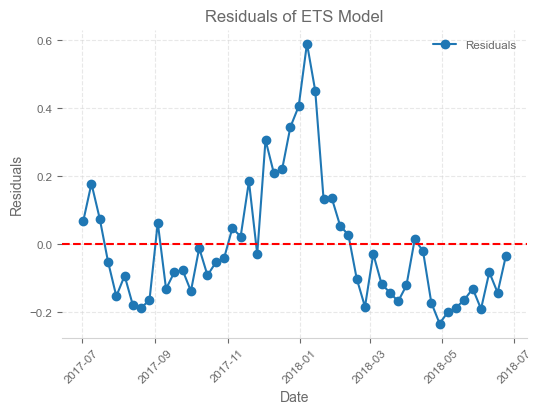

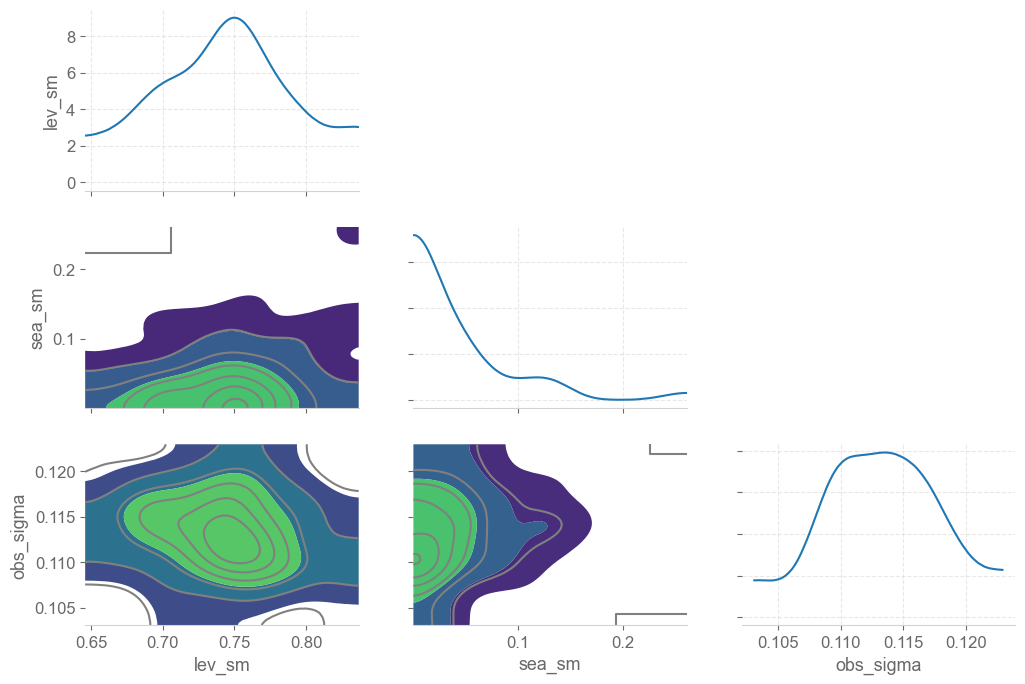

In [30]:
# Plot residuals
plot_residuals(test_df, ets_predicted, date_col, response_col, 'ETS Model')

# Posterior analysis
posterior_analysis(ets_model, var_names=['lev_sm', 'sea_sm', 'obs_sigma'])

## DLT

In [31]:
def tune_dlt(train_df, date_col, response_col, seasonality_options, trend_options):
    """Tune DLT model's seasonality and trend options."""
    best_wmape = float('inf')
    best_params = {}
    for seasonality in seasonality_options:
        for trend in trend_options:
            dlt = DLT(
                response_col=response_col,
                date_col=date_col,
                seasonality=seasonality,
                global_trend_option=trend,
                estimator='stan-map',
                seed=42,
                regressor_col=regressor_col,
            )
            dlt.fit(train_df)
            predicted_df = dlt.predict(df=train_df)
            score = wmape(train_df[response_col], predicted_df['prediction'])
            if score < best_wmape:
                best_wmape = score
                best_params = {'seasonality': seasonality, 'trend': trend}
    print(f"Best DLT params: {best_params} with WMAPE: {best_wmape:.4f}")
    return best_params

In [32]:
# Tune DLT model
seasonality_options = [7, 12, 26, 52]
trend_options = ['linear', 'loglinear', 'flat', 'logistic']
best_params_dlt = tune_dlt(train_df, date_col, response_col, seasonality_options, trend_options)

2024-10-31 05:17:28 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:17:28 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:17:29 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:17:30 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:17:31 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:17:31 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:17:32 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:17:32 

Best DLT params: {'seasonality': 52, 'trend': 'linear'} with WMAPE: 0.0032


In [33]:
def fit_dlt_model(train_df, date_col, response_col, seasonality, trend, regressors):
    """Fit a DLT model."""
    dlt = DLT(
        response_col=response_col,
        date_col=date_col,
        seasonality=seasonality,
        global_trend_option=trend,
        estimator='stan-mcmc',
        seed=42,
        regressor_col=regressors,
        prediction_percentiles=[5, 95],
    )
    dlt.fit(train_df)
    return dlt

In [34]:
# Fit DLT model
dlt_model = fit_dlt_model(
    train_df,
    date_col,
    response_col,
    seasonality=best_params_dlt['seasonality'],
    trend=best_params_dlt['trend'],
    regressors=regressor_col
)

2024-10-31 05:17:38 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (CmdStanPy) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [35]:
# Make predictions
dlt_predicted = make_predictions(dlt_model, test_df)

In [36]:
# Install Arial explicitly to avoid warning messages
import matplotlib as mpl
import matplotlib.font_manager as fm
print(mpl.__version__)

!wget -O Arial.ttf https://github.com/justrajdeep/fonts/raw/master/Arial.ttf
font_dirs = ["/content/"]
font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
for font_file in font_files:
    print(font_file) if 'Arial' in font_file else None
    fm.fontManager.addfont(font_file)

3.7.1
--2024-10-31 05:18:05--  https://github.com/justrajdeep/fonts/raw/master/Arial.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Arial.ttf [following]
--2024-10-31 05:18:06--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Arial.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773236 (755K) [application/octet-stream]
Saving to: ‘Arial.ttf’

Arial.ttf           100%[===================>] 755.11K  --.-KB/s    in 0.06s   

2024-10-31 05:18:06 (13.2 MB/s) - ‘Arial.ttf’ saved [773236/773236]

/content/Arial.ttf


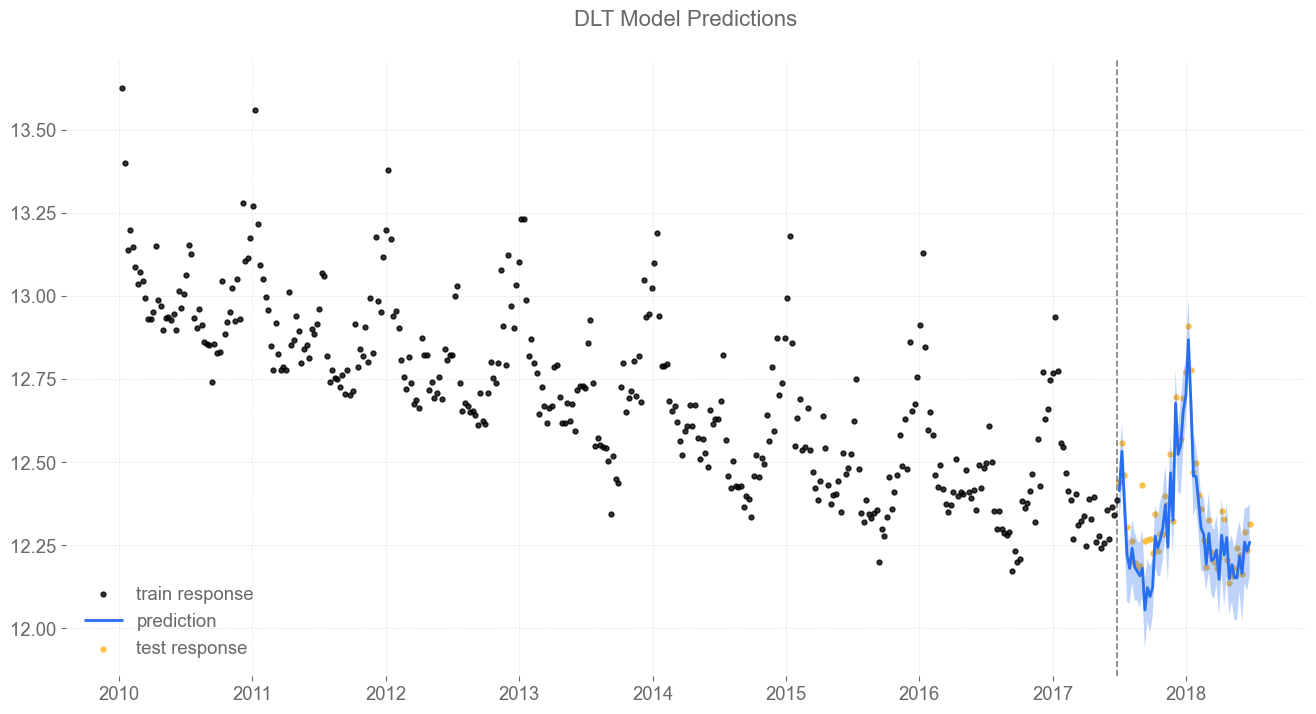

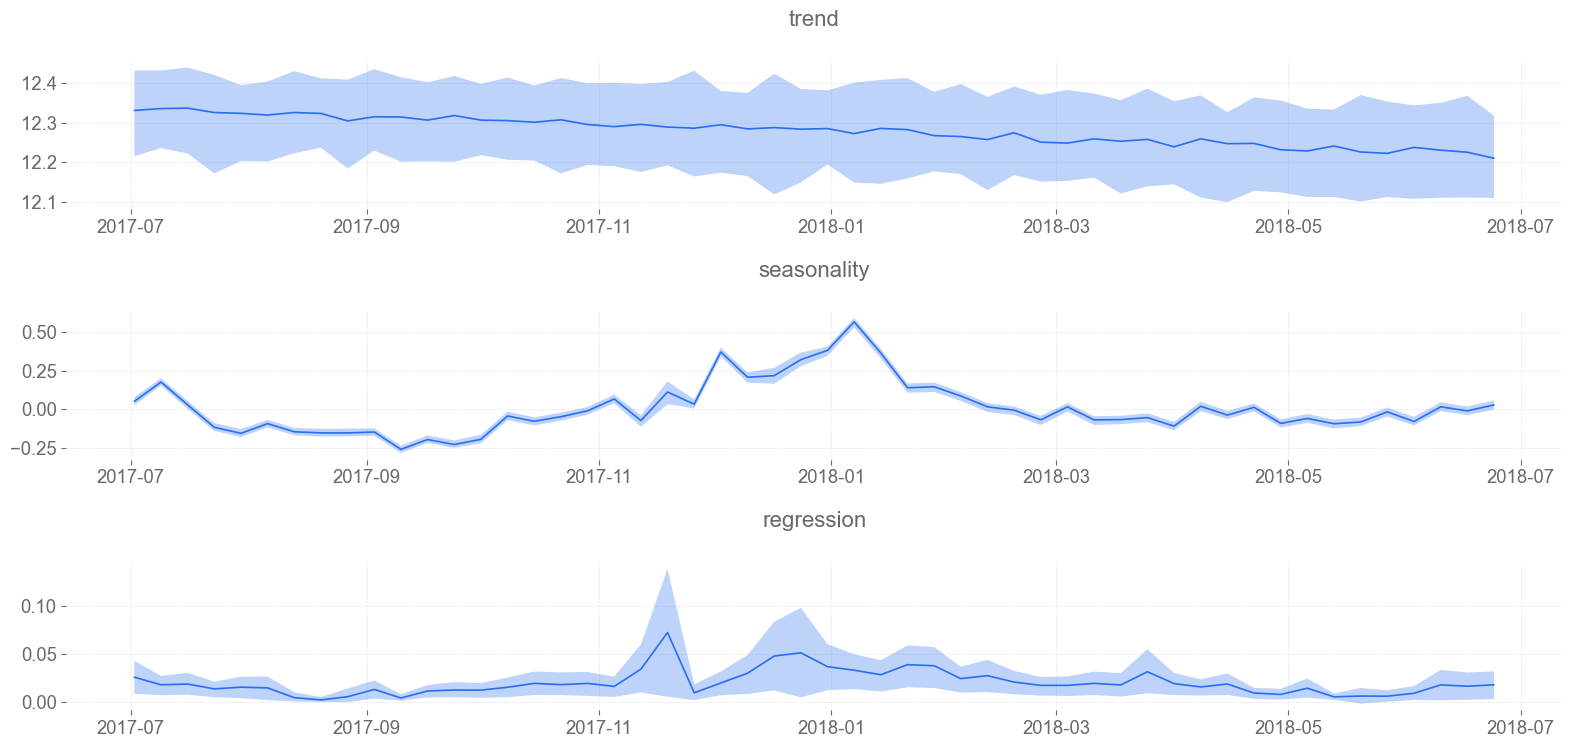

In [37]:
# Visualize predictions
visualize_predictions(train_df, test_df, dlt_predicted, date_col, response_col, 'DLT Model Predictions')

# Visualize components
visualize_components(dlt_predicted, date_col)

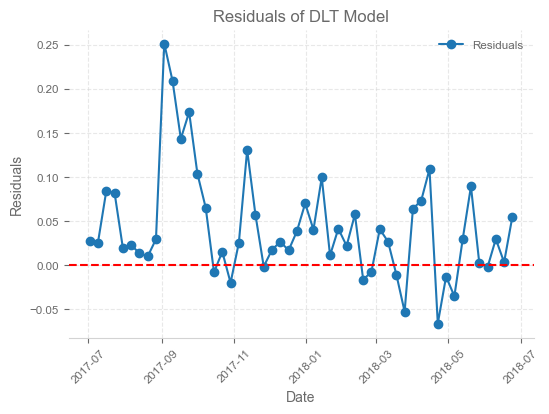

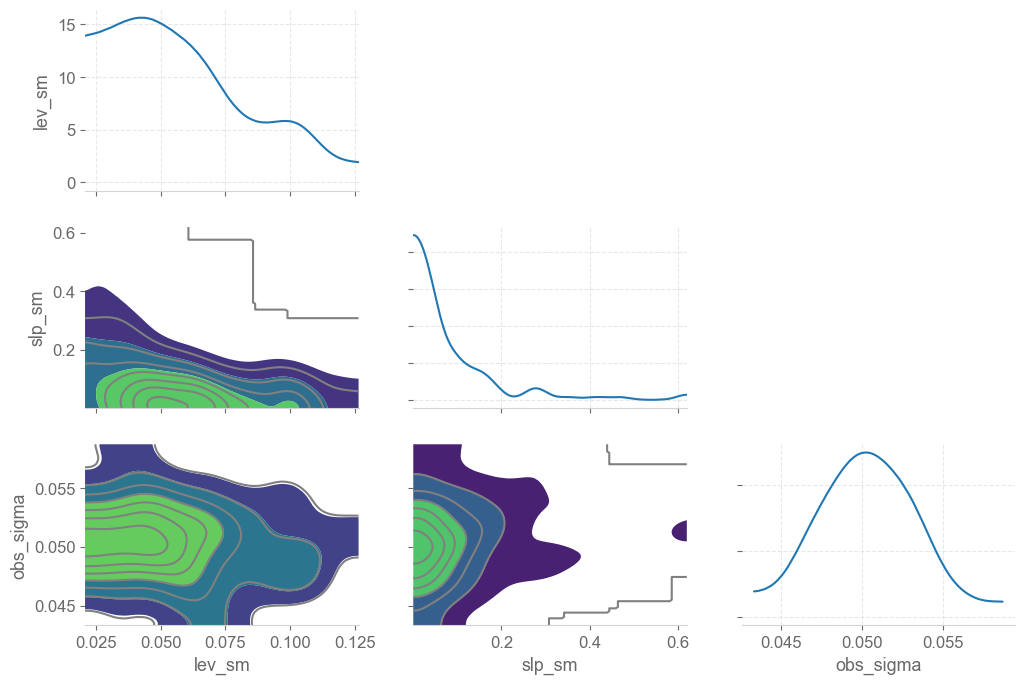

In [38]:
# Plot residuals
plot_residuals(test_df, dlt_predicted, date_col, response_col, 'DLT Model')

# Posterior analysis
posterior_analysis(dlt_model, var_names=['lev_sm', 'slp_sm', 'obs_sigma'])

## KTR

In [39]:
def tune_ktr(train_df, date_col, response_col, seasonality_options):
    """Tune KTR model's seasonality parameter."""
    best_wmape = float('inf')
    best_seasonality = None
    for seasonality in seasonality_options:
        ktr = KTR(
            response_col=response_col,
            date_col=date_col,
            seasonality=seasonality,
            estimator='pyro-svi',
            seed=42,
            regressor_col=regressor_col,
        )
        ktr.fit(train_df)
        predicted_df = ktr.predict(df=train_df)
        score = wmape(train_df[response_col], predicted_df['prediction'])
        if score < best_wmape:
            best_wmape = score
            best_seasonality = seasonality
    print(f"Best KTR seasonality: {best_seasonality} with WMAPE: {best_wmape:.4f}")
    return best_seasonality

In [40]:
# Tune KTR model
seasonality_options = [7, 12, 26, 52]
best_seasonality_ktr = tune_ktr(train_df, date_col, response_col, seasonality_options)

2024-10-31 05:18:11 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:18:11 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2024-10-31 05:18:17 - orbit - INFO - step    0 loss = 452.47, scale = 0.090323
INFO:orbit:step    0 loss = 452.47, scale = 0.090323
2024-10-31 05:18:20 - orbit - INFO - step  100 loss = -195.41, scale = 0.04213
INFO:orbit:step  100 loss = -195.41, scale = 0.04213
2024-10-31 05:18:23 - orbit - INFO - step  200 loss = -197.47, scale = 0.044576
INFO:orbit:step  200 loss = -197.47, scale = 0.044576
2024-10-31 05:18:27 - orbit - INFO - step  300 loss = -203.86, scale = 0.044668
INFO:orbit:step  300 loss = -203.86, scale = 0.044668
2024-10-31 05:18:27 - orbit - INFO - Optim

Best KTR seasonality: 52 with WMAPE: 0.0056


In [41]:
def fit_ktr_model(train_df, date_col, response_col, seasonality, regressors):
    """Fit a KTR model."""
    ktr = KTR(
        response_col=response_col,
        date_col=date_col,
        seasonality=seasonality,
        estimator='pyro-svi',
        seed=42,
        regressor_col=regressors,
        prediction_percentiles=[5, 95],
    )
    ktr.fit(train_df)
    return ktr

In [42]:
# Fit KTR model
ktr_model = fit_ktr_model(train_df, date_col, response_col, best_seasonality_ktr, regressor_col)

2024-10-31 05:18:57 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:18:58 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2024-10-31 05:18:58 - orbit - INFO - step    0 loss = 269.67, scale = 0.090194
INFO:orbit:step    0 loss = 269.67, scale = 0.090194
2024-10-31 05:19:03 - orbit - INFO - step  100 loss = -296.86, scale = 0.037238
INFO:orbit:step  100 loss = -296.86, scale = 0.037238
2024-10-31 05:19:06 - orbit - INFO - step  200 loss = -308.97, scale = 0.037991
INFO:orbit:step  200 loss = -308.97, scale = 0.037991
2024-10-31 05:19:10 - orbit - INFO - step  300 loss = -314.24, scale = 0.038541
INFO:orbit:step  300 loss = -314.24, scale = 0.038541


In [43]:
# Make predictions
ktr_predicted = make_predictions(ktr_model, test_df)

In [44]:
# Install Arial explicitly to avoid warning messages
import matplotlib as mpl
import matplotlib.font_manager as fm
print(mpl.__version__)

!wget -O Arial.ttf https://github.com/justrajdeep/fonts/raw/master/Arial.ttf
font_dirs = ["/content/"]
font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
for font_file in font_files:
    print(font_file) if 'Arial' in font_file else None
    fm.fontManager.addfont(font_file)

3.7.1
--2024-10-31 05:19:10--  https://github.com/justrajdeep/fonts/raw/master/Arial.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Arial.ttf [following]
--2024-10-31 05:19:10--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Arial.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773236 (755K) [application/octet-stream]
Saving to: ‘Arial.ttf’

Arial.ttf           100%[===================>] 755.11K  --.-KB/s    in 0.06s   

2024-10-31 05:19:10 (12.2 MB/s) - ‘Arial.ttf’ saved [773236/773236]

/content/Arial.ttf


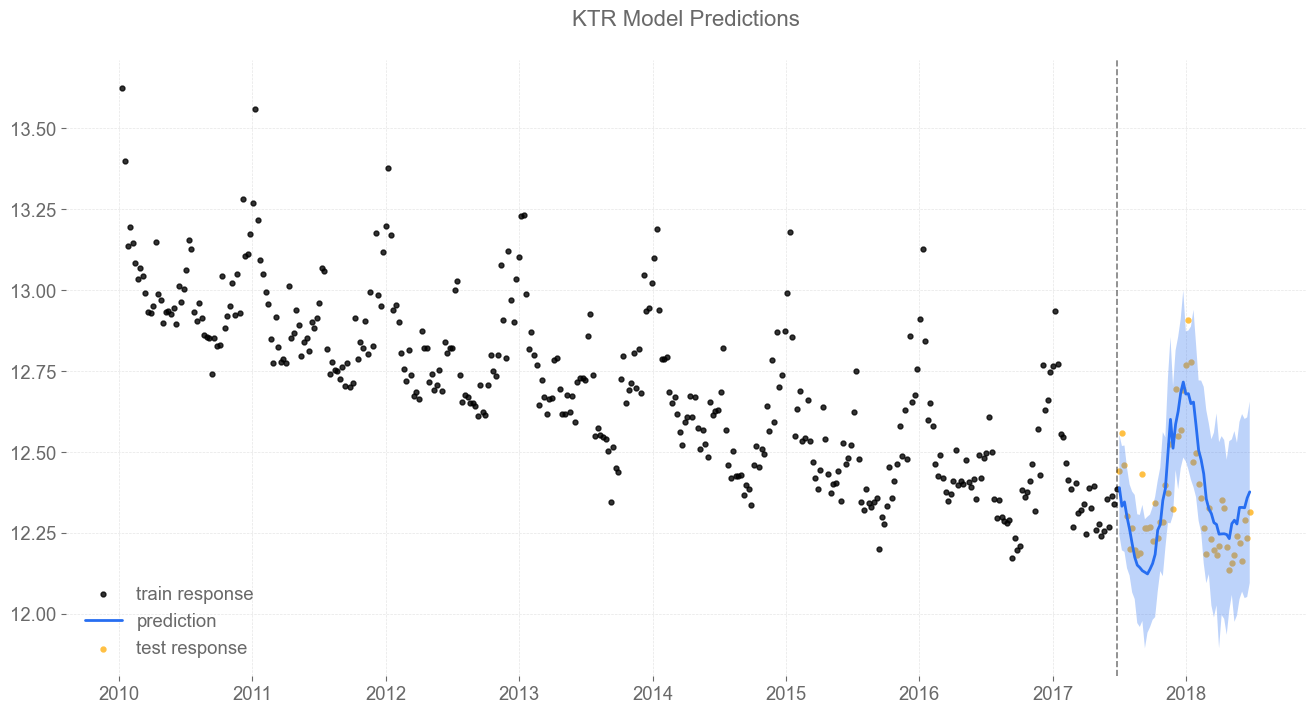

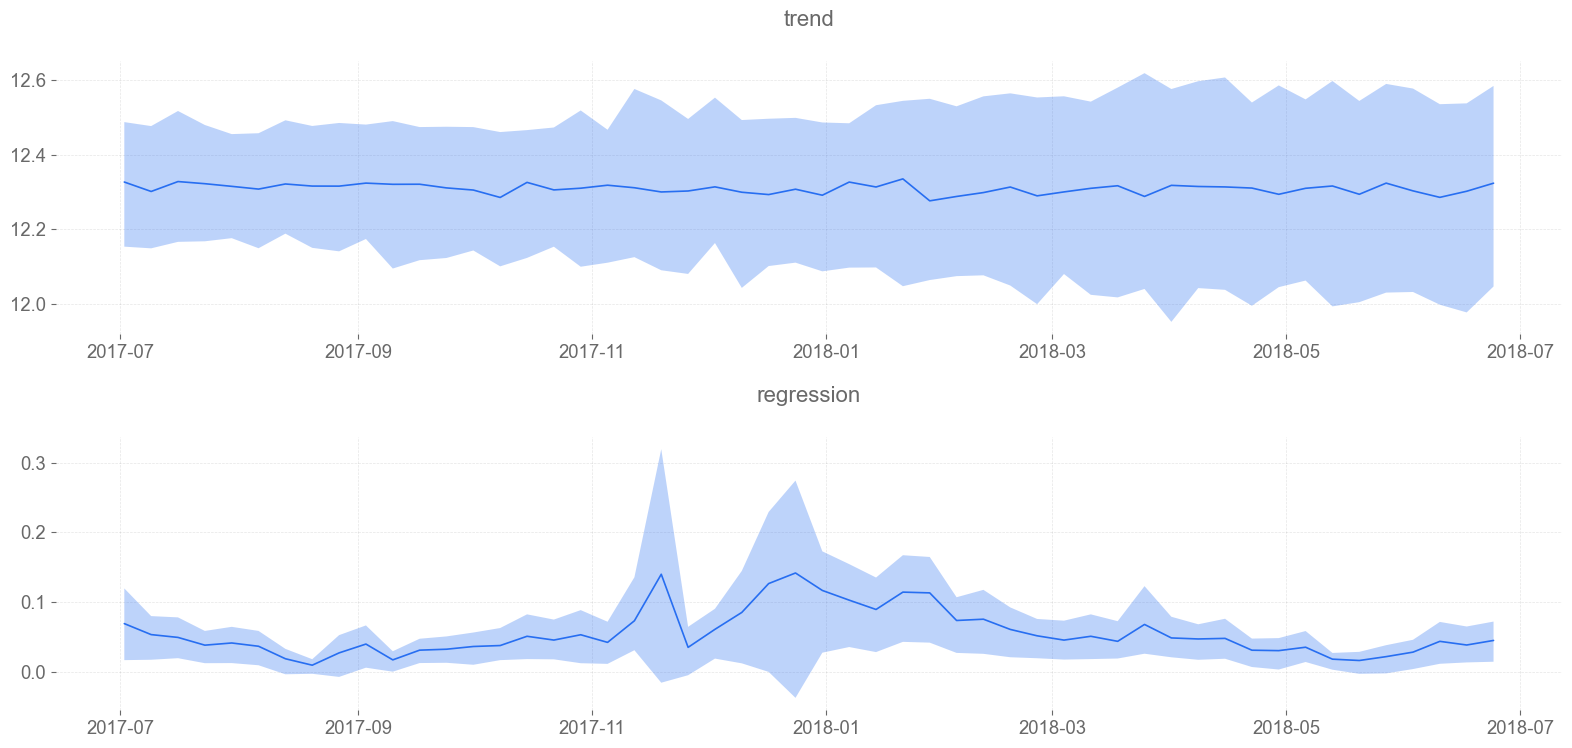

In [45]:
# Visualize predictions
visualize_predictions(train_df, test_df, ktr_predicted, date_col, response_col, 'KTR Model Predictions')

# Visualize components
visualize_components(ktr_predicted, date_col)

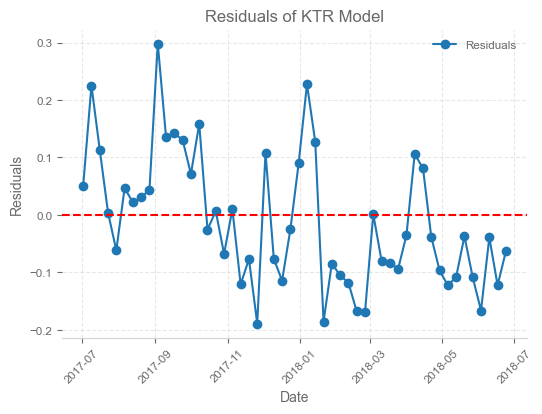

In [46]:
# Plot residuals
plot_residuals(test_df, ktr_predicted, date_col, response_col, 'KTR Model')

## LGT

In [47]:
def tune_lgt(train_df, date_col, response_col, seasonality_options):
    """Tune LGT model's seasonality parameter."""
    best_wmape = float('inf')
    best_seasonality = None
    for seasonality in seasonality_options:
        lgt = LGT(
            response_col=response_col,
            date_col=date_col,
            seasonality=seasonality,
            estimator='stan-map',
            seed=42,
        )
        lgt.fit(train_df)
        predicted_df = lgt.predict(df=train_df)
        score = wmape(train_df[response_col], predicted_df['prediction'])
        if score < best_wmape:
            best_wmape = score
            best_seasonality = seasonality
    print(f"Best LGT seasonality: {best_seasonality} with WMAPE: {best_wmape:.4f}")
    return best_seasonality

In [48]:
# Tune LGT model
seasonality_options = [7, 12, 26, 52]
best_seasonality_lgt = tune_lgt(train_df, date_col, response_col, seasonality_options)

2024-10-31 05:19:11 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:19:12 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:19:12 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-10-31 05:19:12 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.


Best LGT seasonality: 52 with WMAPE: 0.0032


In [49]:
def fit_lgt_model(train_df, date_col, response_col, seasonality):
    """Fit an LGT model."""
    lgt = LGT(
        response_col=response_col,
        date_col=date_col,
        seasonality=seasonality,
        estimator='stan-mcmc',
        seed=42,
        prediction_percentiles=[5, 95],
    )
    lgt.fit(train_df)
    return lgt

In [50]:
# Fit LGT model
lgt_model = fit_lgt_model(
    train_df,
    date_col,
    response_col,
    seasonality=best_seasonality_lgt
)

2024-10-31 05:19:12 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (CmdStanPy) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [51]:
# Make predictions
lgt_predicted = make_predictions(lgt_model, test_df)

In [52]:
# Install Arial explicitly to avoid warning messages
import matplotlib as mpl
import matplotlib.font_manager as fm
print(mpl.__version__)

!wget -O Arial.ttf https://github.com/justrajdeep/fonts/raw/master/Arial.ttf
font_dirs = ["/content/"]
font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
for font_file in font_files:
    print(font_file) if 'Arial' in font_file else None
    fm.fontManager.addfont(font_file)

3.7.1
--2024-10-31 05:19:40--  https://github.com/justrajdeep/fonts/raw/master/Arial.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Arial.ttf [following]
--2024-10-31 05:19:40--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Arial.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773236 (755K) [application/octet-stream]
Saving to: ‘Arial.ttf’

Arial.ttf           100%[===================>] 755.11K  --.-KB/s    in 0.06s   

2024-10-31 05:19:40 (13.2 MB/s) - ‘Arial.ttf’ saved [773236/773236]

/content/Arial.ttf


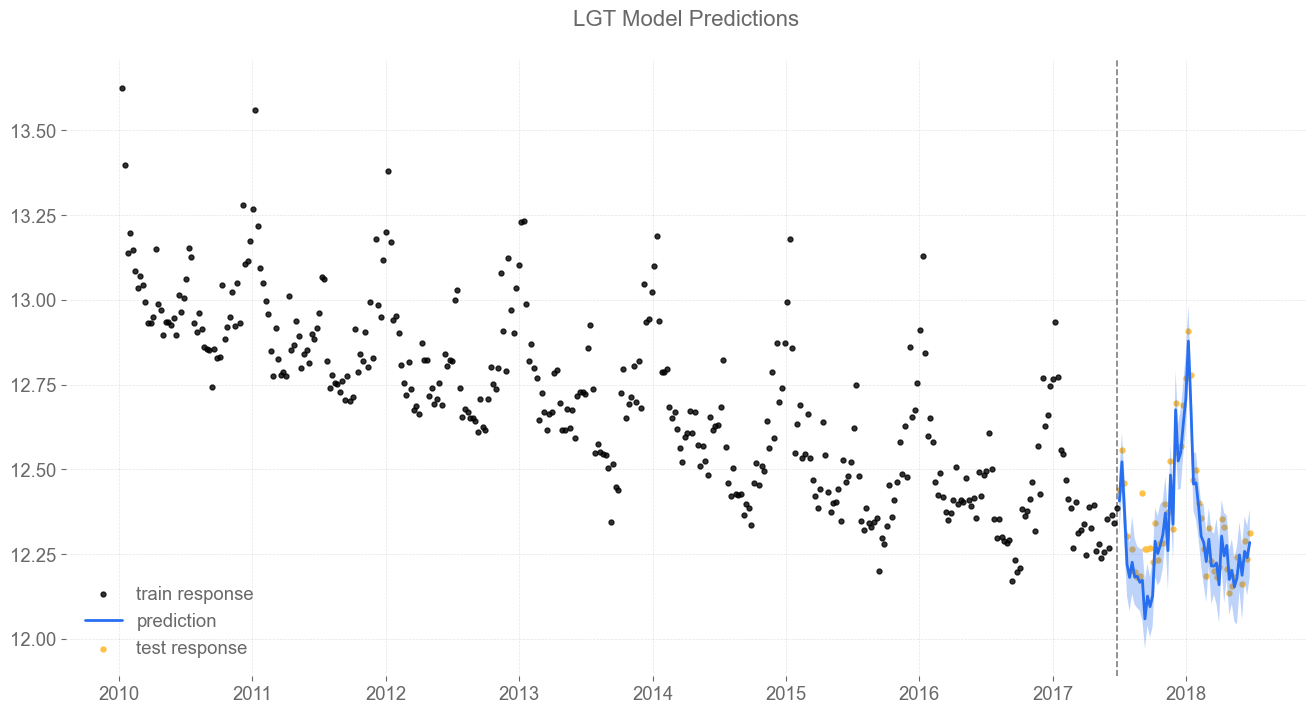

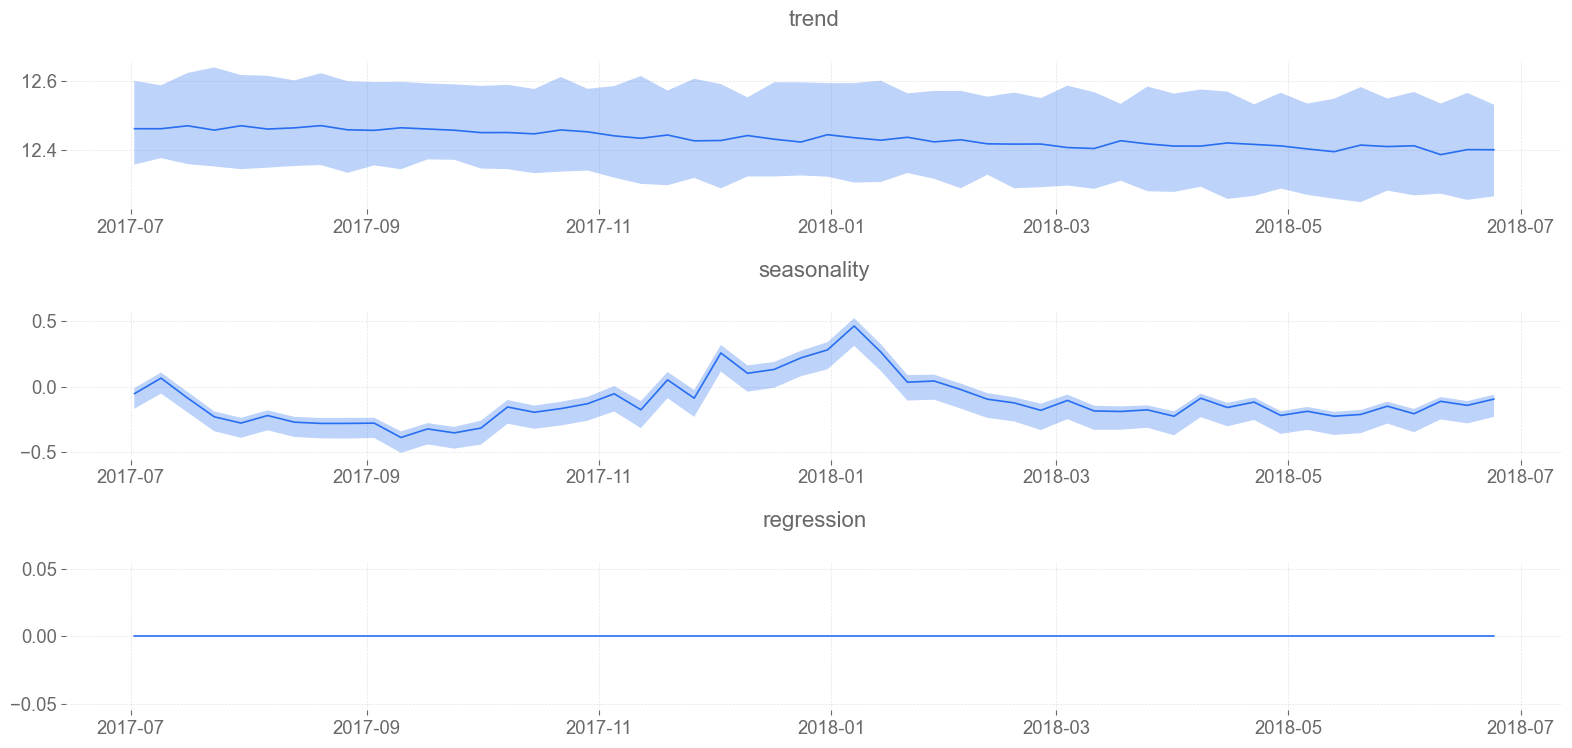

In [53]:
# Visualize predictions
visualize_predictions(train_df, test_df, lgt_predicted, date_col, response_col, 'LGT Model Predictions')

# Visualize components
visualize_components(lgt_predicted, date_col)

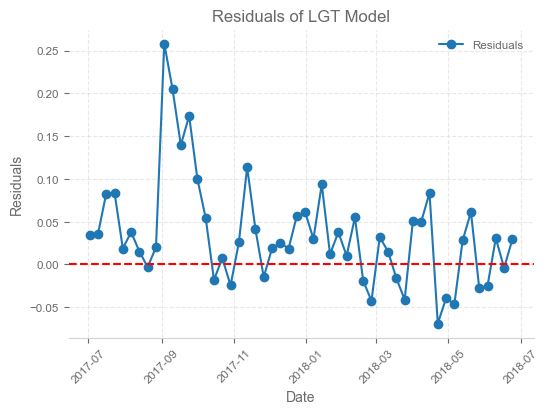

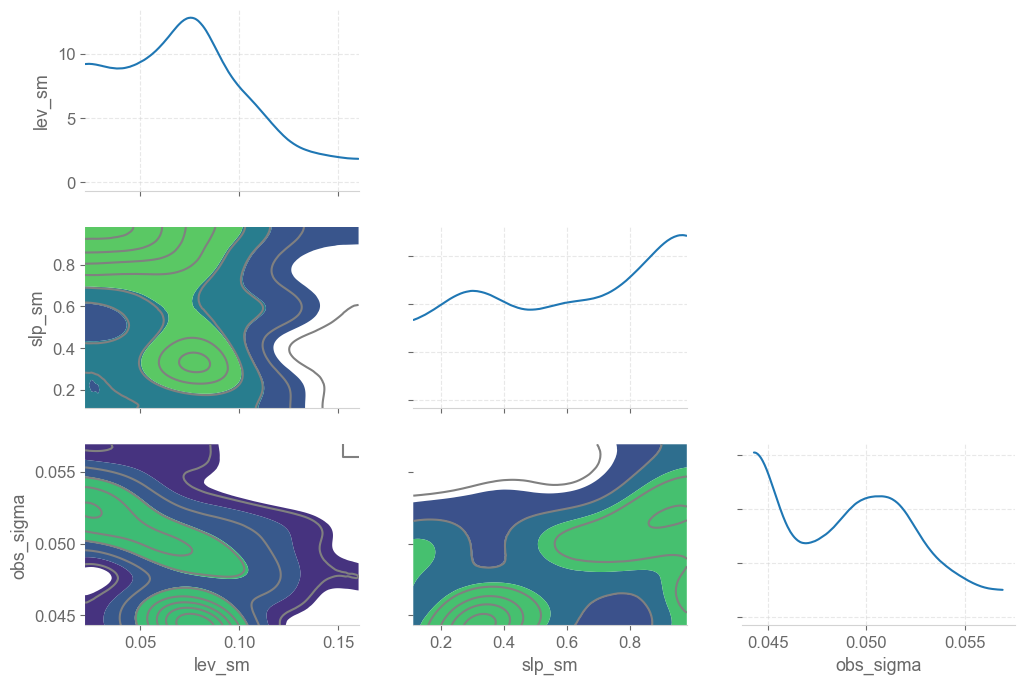

In [54]:
# Plot residuals
plot_residuals(test_df, lgt_predicted, date_col, response_col, 'LGT Model')

# Posterior analysis
posterior_analysis(lgt_model, var_names=['lev_sm', 'slp_sm', 'obs_sigma'])

# Model Evaluation

In [55]:
def evaluate_models(test_df, predicted_dfs, response_col):
    """Evaluate models using multiple metrics."""
    metrics = {}
    for model_name, predicted_df in predicted_dfs.items():
        y_true = test_df[response_col].values
        y_pred = predicted_df['prediction'].values
        wmape_score = wmape(y_true, y_pred)
        mape_score = mape(y_true, y_pred)
        mae_score = mean_absolute_error(y_true, y_pred)
        rmse_score = np.sqrt(mean_squared_error(y_true, y_pred))
        metrics[model_name] = {
            'WMAPE': wmape_score,
            'MAPE': mape_score,
            'MAE': mae_score,
            'RMSE': rmse_score
        }
    return metrics

In [56]:
# Create a dictionary of predicted dataframes
predicted_dfs = {
    'ETS Model': ets_predicted,
    'DLT Model': dlt_predicted,
    'KTR Model': ktr_predicted,
    'LGT Model': lgt_predicted,
}

# Evaluate models
metrics = evaluate_models(test_df, predicted_dfs, response_col)

# Display the metrics
metrics_df = pd.DataFrame(metrics).T
display(metrics_df)

,WMAPE,MAPE,MAE,RMSE
ETS Model,0.011547,1.147431,0.142582,0.181927
DLT Model,0.004178,0.417354,0.051593,0.073537
KTR Model,0.007807,0.778960,0.096400,0.114579
LGT Model,0.004109,0.410673,0.050741,0.071122


In [57]:
def compare_models(test_df, date_col, response_col, predictions_dict):
    """Compare multiple models' predictions."""
    plt.figure(figsize=(8, 4))
    plt.plot(test_df[date_col], test_df[response_col], label='Actual', linewidth=2)
    for model_name, predicted_df in predictions_dict.items():
        plt.plot(test_df[date_col], predicted_df['prediction'], label=model_name)
    plt.title('Model Predictions Comparison')
    plt.xlabel('Date')
    plt.ylabel('Claims')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.show()

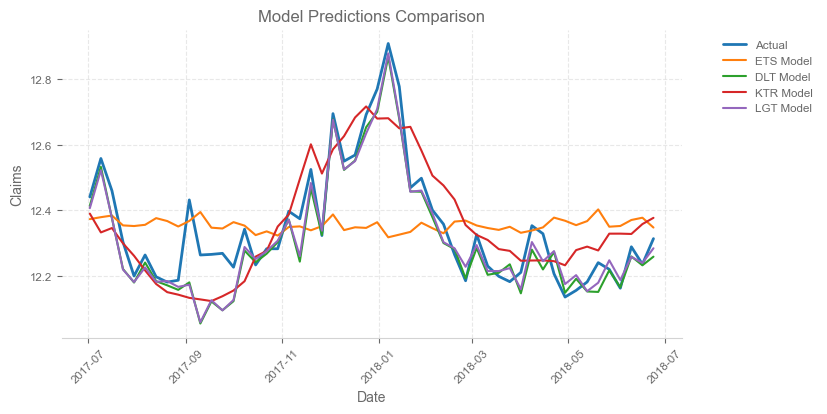

In [58]:
# Compare models
compare_models(test_df, date_col, response_col, predicted_dfs)

In [59]:
def forecast_future(model, periods, date_col, freq='W'):
    """Forecast future values using the fitted model."""
    last_date = train_df[date_col].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=periods, freq=freq)
    future_df = pd.DataFrame({date_col: future_dates})
    predicted_df = model.predict(future_df)
    return predicted_df

In [60]:
# Forecast future values
future_predicted = forecast_future(lgt_model, periods=52, date_col=date_col)

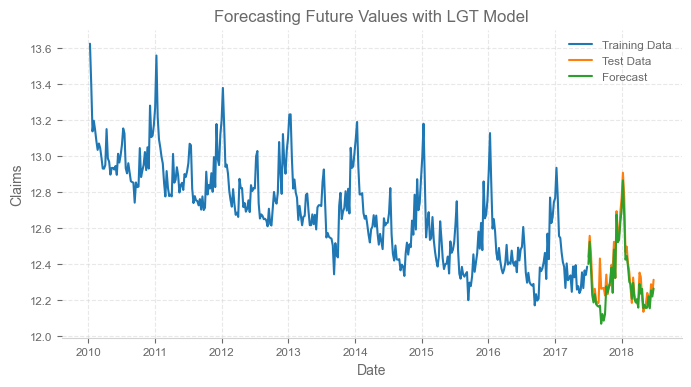

In [61]:
# Visualize the forecast
plt.figure(figsize=(8, 4))
plt.plot(train_df[date_col], train_df[response_col], label='Training Data')
plt.plot(test_df[date_col], test_df[response_col], label='Test Data')
plt.plot(future_predicted[date_col], future_predicted['prediction'], label='Forecast')
plt.title('Forecasting Future Values with LGT Model')
plt.xlabel('Date')
plt.ylabel('Claims')
plt.legend()
plt.show()

In [62]:
def visualize_predictions_with_intervals(train_df, test_df, predicted_df, date_col, response_col, title):
    """Visualize actual vs. predicted values with credible intervals."""
    plt.figure(figsize=(8, 4))

    # Plot training data
    plt.plot(train_df[date_col], train_df[response_col], label='Training Data', color='blue')

    # Plot test data
    plt.plot(test_df[date_col], test_df[response_col], label='Test Data', color='orange')

    # Plot predictions
    plt.plot(predicted_df[date_col], predicted_df['prediction'], label='Predictions', color='green')

    # Identify percentile columns
    percentile_cols = [col for col in predicted_df.columns if 'prediction_' in col and col != 'prediction']
    if len(percentile_cols) >= 2:
        lower_bound = predicted_df[percentile_cols[0]]
        upper_bound = predicted_df[percentile_cols[1]]
        interval_label = f"{percentile_cols[0].split('_')[-1]}-{percentile_cols[1].split('_')[-1]}% Credible Interval"
        plt.fill_between(predicted_df[date_col], lower_bound, upper_bound, color='lightgreen', alpha=0.3, label=interval_label)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(response_col.capitalize())
    plt.legend()
    plt.show()

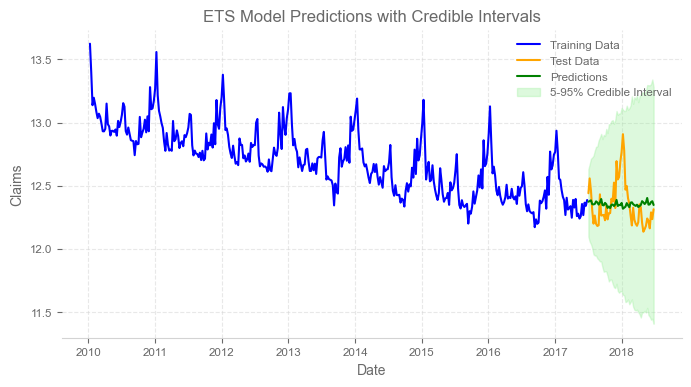

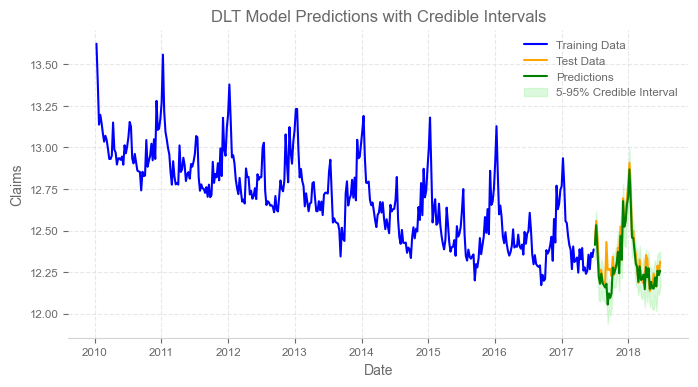

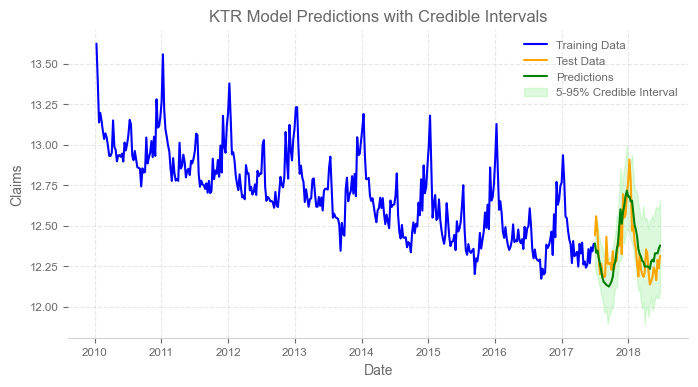

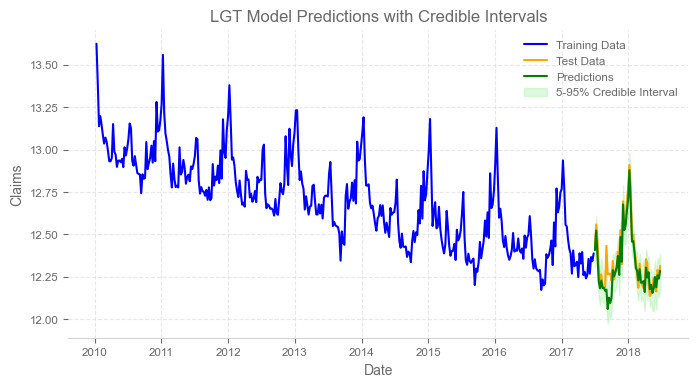

In [63]:
# ETS Model
visualize_predictions_with_intervals(
    train_df, test_df, ets_predicted, date_col, response_col, 'ETS Model Predictions with Credible Intervals'
)

# DLT Model
visualize_predictions_with_intervals(
    train_df, test_df, dlt_predicted, date_col, response_col, 'DLT Model Predictions with Credible Intervals'
)

# KTR Model
visualize_predictions_with_intervals(
    train_df, test_df, ktr_predicted, date_col, response_col, 'KTR Model Predictions with Credible Intervals'
)

# LGT Model
visualize_predictions_with_intervals(
    train_df, test_df, lgt_predicted, date_col, response_col, 'LGT Model Predictions with Credible Intervals'
)